## 统计VAW

In [466]:
import json
import os.path as osp
import numpy as np

data_path = '/data/liangkongming/data/vaw_dataset/data'

with open(osp.join(data_path, 'object_index.json')) as f:
    object_index = json.load(f)
    
with open(osp.join(data_path, 'attribute_index.json')) as f:
    attribute_index = json.load(f)
    
anno = {}
for stage in ['train', 'val', 'test']:
    with open(osp.join(data_path, '{}.json'.format(stage))) as f:
        anno[stage] = json.load(f)

In [234]:
num_obj = len(object_index)
num_att = len(attribute_index)
print(num_obj, num_att)

2260 620


### 每种物体类别的属性分布在train/val/test上的差异

In [260]:
def calculate_num(anno_list, num_obj, num_att):
    obj_att_anno_pos = np.zeros((num_obj, num_att))
    obj_att_anno_neg = np.zeros((num_obj, num_att))
    obj_counter = np.zeros((num_obj))

    for anno_image in anno_list:
        object_name = anno_image['object_name']
        positive_attributes = anno_image['positive_attributes']
        negative_attributes = anno_image['negative_attributes']
        object_index_image = object_index[object_name]
        obj_counter[object_index_image] += 1
        for att in positive_attributes:
            attribute_index_image = attribute_index[att]
            obj_att_anno_pos[object_index_image, attribute_index_image] += 1
        for att in negative_attributes:
            attribute_index_image = attribute_index[att]
            obj_att_anno_neg[object_index_image, attribute_index_image] +=1
    return obj_att_anno_pos, obj_att_anno_neg, obj_counter

oa_anno_pos_train, oa_anno_neg_train, obj_counter_train = calculate_num(
    anno['train'], num_obj, num_att
)

In [252]:
oa_anno_pos_val, oa_anno_neg_val, obj_counter_val = calculate_num(
    anno['val'], num_obj, num_att
)
print(((oa_anno_pos_train == 0) * (oa_anno_pos_val != 0)).sum() , (oa_anno_pos_val != 0).sum())
print(((oa_anno_pos_train == 0) * (oa_anno_pos_val != 0)).sum() / (oa_anno_pos_val != 0).sum())

1296 8876
0.14601171698963497


In [253]:
oa_anno_pos_test, oa_anno_neg_test, obj_counter_test = calculate_num(
    anno['test'], num_obj, num_att
)
print(((oa_anno_pos_train == 0) * (oa_anno_pos_test != 0)).sum() , (oa_anno_pos_test != 0).sum())
print(((oa_anno_pos_train == 0) * (oa_anno_pos_test != 0)).sum() / (oa_anno_pos_test != 0).sum())

3881 16527
0.2348278574453924


In [45]:
object_index_reversed = {v:k for k, v in object_index.items()}
attribute_index_reversed = {v:k for k, v in attribute_index.items()}

### 获取物体类别的可描述属性

In [451]:
oa_anno_pos = oa_anno_pos_train + oa_anno_pos_val + oa_anno_pos_test
oa_anno_neg = oa_anno_neg_train + oa_anno_neg_val + oa_anno_neg_test
valid_att_per_obj = {}
for ii in range(num_obj):
    valid_att_list = []
    valid_att = np.where((oa_anno_pos[ii]+oa_anno_neg[ii]) > 0)[0]
    for jj in valid_att:
        valid_att_list.append(attribute_index_reversed[jj])
    valid_att_per_obj[object_index_reversed[ii]] = valid_att_list

In [470]:
def check_invalid_att(anno_image, valid_att_per_obj):
    object_name = anno_image['object_name']
    positive_attributes = anno_image['positive_attributes']
    negative_attributes = anno_image['negative_attributes']
    valid_att = valid_att_per_obj[object_name]
#     print(len(positive_attributes+negative_attributes), len(valid_att))
    for att in positive_attributes + negative_attributes:
        assert(att in valid_att)
        
for anno_image in anno['train']+anno['val']+anno['test']:
# for anno_image in anno['train'][0:100]:
    check_invalid_att(anno_image, valid_att_per_obj)
#     break

In [495]:
oa_flag.sum(), num_obj*num_att, oa_flag.sum()/(num_obj*num_att)

(45342.0, 1401200, 0.03235940622323723)

In [ ]:
# 已经验证对于测试数据引入aux信息后，无性能影响
oa_flag = np.zeros((num_obj, num_att))
for ii in range(num_obj):
    object_name = object_index_reversed[ii]
    valid_att = valid_att_per_obj[object_name]
    for jj in range(num_att):
        attribute_name = attribute_index_reversed[jj]
        if attribute_name in valid_att:
            oa_flag[ii, jj] = 1
            
result_path = '/data/liangkongming/code/KGVA/exp/preds-negative_224_rn50_obj.npy'
preds = np.load(result_path)
for ii, anno_image in enumerate(anno['test']):
    object_name = anno_image['object_name']
    preds[ii] *= oa_flag[object_index[object_name]]
np.save('/data/liangkongming/code/KGVA/exp/preds-negative_224_rn50_obj_aux.npy', preds)

In [527]:
input_path = '/data/liangkongming/data/vaw_dataset/data'

with open(osp.join(input_path, 'train.json')) as f:
    anno_train = json.load(f)

In [528]:
print(len(anno_train))

anno_output = []
for anno_image in anno_train:
    object_name = anno_image['object_name']
    positive_attributes = anno_image['positive_attributes']
    negative_attributes = anno_image['negative_attributes']
    anno_image['candidate_attributes'] = []
    valid_att = valid_att_per_obj[object_name]
    for att in valid_att:
        if att not in positive_attributes and att not in negative_attributes:
            anno_image['candidate_attributes'].append(att)
    anno_output.append(anno_image)

print(len(anno_output))

216790
216790


In [529]:
output_path = '/data/liangkongming/data/vaw_dataset/data-20230201'
with open(osp.join(output_path, 'train.json'), 'w') as f:
    json.dump(anno_output, f)

In [530]:
with open(osp.join(output_path, 'train.json')) as f:
    anno_train = json.load(f)

In [914]:
data_idx = 1000
print(anno_train[data_idx]['object_name'])
for k in ['positive_attributes', 'negative_attributes', 'candidate_attributes']:
    print(k, anno_train[data_idx][k])

keys
positive_attributes ['white', 'silver', 'square']
negative_attributes ['plastic', 'dark']
candidate_attributes ['black', 'gray', 'small', 'metal', 'wavy']


### OA组合在train、val、test上的差异
* internal knowledge
* external knowledge

#### co-occurence

In [876]:
EPS = np.finfo(float).eps

def normalize_array(input_array):
    ''' normalize along x axis '''
    output_array = input_array / (np.sqrt((input_array **2).sum(axis = 1))[:, np.newaxis] + EPS)
    return output_array

In [877]:
oa_train = oa_anno_pos_train + oa_anno_neg_train
oa_train_norm = normalize_array(oa_train)
# oa_train_norm1 = oa_train_num / (np.sqrt((oa_train_num **2).sum(axis = 1))[:, np.newaxis] + EPS)
obj_corr_internal = oa_train_norm.astype(float) @ oa_train_norm.astype(float).T

#### embedding

In [878]:
import torch

embed_path = '/data/liangkongming/code/KGVA/data/wxr/embeddings/clip_obj_embs_d512.pth'
# embed_path = '/data/liangkongming/code/KGVA/data/wxr/embeddings/bert_obj_embs_d768.pth'
# embed_path = '/data/liangkongming/code/KGVA/data/wxr/embeddings/glove_obj_embs_d100.pth'
obj_emb = torch.load(embed_path).numpy()
obj_emb = normalize_array(obj_emb)
obj_corr_external = obj_emb.astype(float) @ obj_emb.astype(float).T

#### merge knowledge

In [936]:
oa_trainval_flag = (oa_anno_pos_train + oa_anno_neg_train + oa_anno_pos_val + oa_anno_neg_val) > 0
oa_test_flag = (oa_anno_pos_test + oa_anno_neg_test) > 0

In [992]:
def get_att_IoU(list1, list2):
    inter_att = (list1 & list2).sum()
    union_att = (list1 | list2).sum()
    return inter_att, union_att

# obj_correlation.shape
obj_correlation1_norm = normalize_array(obj_corr_internal)
obj_correlation2_norm = normalize_array(obj_corr_external)
obj_correlation = np.maximum(obj_correlation1_norm, obj_correlation2_norm)
oa_flag = np.zeros_like(oa_trainval_flag).astype(np.uint8)
output = []
# for ii in range(5, num_obj):
for ii in range(num_obj):
    inter_att, union_att = get_att_IoU(oa_trainval_flag[ii], oa_test_flag[ii])
    TOP_K = 4
    sorted_index = np.argsort(obj_correlation1[ii])
    top_k_list = sorted_index[-TOP_K:][::-1]
#     oa_flag[ii] = oa_train_flag[ii]
    for o in top_k_list:
        if o == ii:
            continue
        oa_flag[ii] += oa_trainval_flag[o]
        
    sorted_index = np.argsort(obj_correlation2[ii])
    top_k_list = sorted_index[-TOP_K:][::-1]
    for o in top_k_list:
        if o == ii:
            continue
        oa_flag[ii] += oa_trainval_flag[o]
        
    oa_flag[ii] = (oa_flag[ii] >= 3) + oa_trainval_flag[ii]
#     print(np.where(oa_flag[ii]>2))
#     best_match = top_k_list[1] if top_k_list[0] == ii else top_k_list[0]
#     oa_flag[ii] = oa_train_flag[ii] + oa_train_flag[best_match]
    inter_att_aug, union_att_aug = get_att_IoU(oa_flag[ii], oa_test_flag[ii])
#     print(inter_att, union_att, inter_att_aug, union_att_aug)
#     ((+oa_train_flag[best_match]) & oa_valtest_flag[ii]).sum()
#     union_att_aug = ((oa_train_flag[ii]+oa_train_flag[best_match]) | oa_valtest_flag[ii]).sum()
#     return inter_att_aug, union_att_aug

#     inter_att_aug, union_att_aug = get_att_IoU(ii, obj_correlation[ii])
#     inter_att_aug1, union_att_aug1 = get_att_IoU(ii, obj_correlation1[ii])
#     inter_att_aug2, union_att_aug2 = get_att_IoU(ii, obj_correlation2[ii])
    if inter_att_aug > inter_att:
        output.append([object_index_reversed[ii], inter_att, inter_att_aug])
#     break

# print('{0}, {1}, {2}'.format(len(output), num_obj, len(output)/num_obj))
print(len(output), (oa_flag * oa_test_flag).sum()/oa_test_flag.sum(), oa_flag.sum(), (oa_trainval_flag+oa_test_flag).sum())

252 0.7736394135188867 44698 45342


In [994]:
252/num_obj

0.11150442477876106

In [974]:
Trainval:
0.7609033300198808, 37645

Combine:
TOP1, C=1: 466 0.8040196322067594 61487 45342
TOP2, C=1: 653 0.8309517892644135 84527 45342
TOP2, C=2: 218 0.7756585487077535 42899 45342
TOP2, C=2: 389 0.7921222664015904 50905 45342
            97 0.7647241550695825 39993 45342

        55 0.7627671471172962 38634 45342

(25883, 61487)

In [ ]:
oa_flag = np.zeros_like(oa_trainval_flag).astype(np.uint8)
output = []
# for ii in range(5, num_obj):
for ii in range(num_obj):
    inter_att, union_att = get_att_IoU(oa_trainval_flag[ii], oa_test_flag[ii])
    TOP_K = 2
    
    oa_flag1 = np.zeros_like(oa_flag[ii]).astype(np.uint8)
    sorted_index = np.argsort(obj_correlation1[ii])
    top_k_list = sorted_index[-TOP_K:][::-1]
#     oa_flag[ii] = oa_train_flag[ii]
    for o in top_k_list:
        if o == ii:
            continue
        oa_flag1 += oa_trainval_flag[o]
    oa_flag1 = (oa_flag1 >= 1)
        
    oa_flag2 = np.zeros_like(oa_flag[ii]).astype(np.uint8)
    sorted_index = np.argsort(obj_correlation2[ii])
    top_k_list = sorted_index[-TOP_K:][::-1]
    for o in top_k_list:
        if o == ii:
            continue
        oa_flag2 += oa_trainval_flag[o]
    oa_flag2 = (oa_flag2 >= 1)

    oa_flag[ii] = (oa_flag1*oa_flag2) + oa_trainval_flag[ii]
    inter_att_aug, union_att_aug = get_att_IoU(oa_flag[ii], oa_test_flag[ii])
    if inter_att_aug > inter_att:
        output.append([object_index_reversed[ii], inter_att, inter_att_aug])
        
print(len(output), (oa_flag * oa_test_flag).sum()/oa_test_flag.sum(), oa_flag.sum(), (oa_trainval_flag+oa_test_flag).sum())

In [895]:
def get_att_IoU(list1, list2):
    inter_att = (list1 & list2).sum()
    union_att = (list1 | list2).sum()
    return inter_att, union_att

# obj_correlation.shape
obj_correlation1_norm = normalize_array(obj_correlation1)
obj_correlation2_norm = normalize_array(obj_correlation2)
obj_correlation = np.maximum(obj_correlation1_norm, obj_correlation2_norm)
oa_flag = np.zeros_like(oa_train_flag)
output = []
for ii in range(num_obj):
    inter_att, union_att = get_att_IoU(oa_train_flag[ii], oa_valtest_flag[ii])
    TOP_K = 2
    sorted_index = np.argsort(obj_correlation[ii])
    top_k_list = sorted_index[-TOP_K:][::-1]
    best_match = top_k_list[1] if top_k_list[0] == ii else top_k_list[0]
    oa_flag[ii] = oa_train_flag[ii] + oa_train_flag[best_match]
    inter_att_aug, union_att_aug = get_att_IoU(oa_flag[ii], oa_valtest_flag[ii])
#     ((+oa_train_flag[best_match]) & oa_valtest_flag[ii]).sum()
#     union_att_aug = ((oa_train_flag[ii]+oa_train_flag[best_match]) | oa_valtest_flag[ii]).sum()
#     return inter_att_aug, union_att_aug

#     inter_att_aug, union_att_aug = get_att_IoU(ii, obj_correlation[ii])
#     inter_att_aug1, union_att_aug1 = get_att_IoU(ii, obj_correlation1[ii])
#     inter_att_aug2, union_att_aug2 = get_att_IoU(ii, obj_correlation2[ii])
    if inter_att_aug > inter_att:
        output.append([object_index_reversed[ii], inter_att, inter_att_aug])

print('{0}, {1}, {2}'.format(len(output), num_obj, len(output)/num_obj))

515, 2260, 0.22787610619469026


In [897]:
oa_flag.sum(), oa_train_flag.sum(), (oa_train_flag == 0).sum()

(57488, 35292, 1365908)

In [901]:
# valid_att_per_obj = {}
# for ii in range(num_obj):
#     valid_att = np.where((oa_flag[ii]) > 0)[0]
#     valid_att_list = [attribute_index_reversed[x] for x in valid_att]
#     valid_att_per_obj[object_index_reversed[ii]] = valid_att_list

In [930]:
valid_att_per_obj = {}
for ii in range(num_obj):
    valid_att = np.where((oa_train_flag[ii]+oa_val_flag[ii]) > 0)[0]
    valid_att_list = [attribute_index_reversed[x] for x in valid_att]
    valid_att_per_obj[object_index_reversed[ii]] = valid_att_list

#### save data

In [931]:
input_path = '/data/liangkongming/data/vaw_dataset/data'

with open(osp.join(input_path, 'train.json')) as f:
    anno_train = json.load(f)

In [932]:
print(len(anno_train))

anno_output = []
for anno_image in anno_train:
    object_name = anno_image['object_name']
    positive_attributes = anno_image['positive_attributes']
    negative_attributes = anno_image['negative_attributes']
    anno_image['candidate_attributes'] = []
    valid_att = valid_att_per_obj[object_name]
    for att in valid_att:
        if att not in positive_attributes and att not in negative_attributes:
            anno_image['candidate_attributes'].append(att)
    anno_output.append(anno_image)

print(len(anno_output))

216790
216790


In [933]:
output_path = '/data/liangkongming/data/vaw_dataset/data-20230206-trainval'
with open(osp.join(output_path, 'train.json'), 'w') as f:
    json.dump(anno_output, f)

In [934]:
with open(osp.join(output_path, 'train.json')) as f:
    anno_train = json.load(f)

In [935]:
data_idx = 6
print(anno_train[data_idx]['object_name'])
for k in ['positive_attributes', 'negative_attributes', 'candidate_attributes']:
    print(k, anno_train[data_idx][k])

wall
positive_attributes ['tiled', 'white']
negative_attributes ['large']
candidate_attributes ['amber', 'aqua', 'beige', 'black', 'blue', 'bluish', 'bright blue', 'bright green', 'bright red', 'bright yellow', 'bronze', 'brown', 'burgundy', 'cream colored', 'dark blue', 'dark brown', 'dark gray', 'dark green', 'dark pink', 'dark purple', 'dark red', 'fuchsia', 'golden', 'golden brown', 'gray', 'green', 'ivory', 'light blue', 'light brown', 'light green', 'light gray', 'light red', 'light yellow', 'lime green', 'maroon', 'murky', 'navy blue', 'neon green', 'off white', 'olive green', 'orange', 'pale blue', 'pale green', 'pink', 'purple', 'red', 'reddish', 'rust colored', 'silver', 'tan', 'taupe', 'teal', 'terracotta', 'turquoise', 'violet', 'yellow', 'red lettered', 'wearing white', 'light colored', 'dark colored', 'colorful', 'monochromatic', 'multicolored', 'bright', 'dark', 'high', 'low', 'tall', 'short', 'long', 'wide', 'narrow', 'thin', 'huge', 'small', 'thick', 'asphalt', 'bamboo

In [926]:
data_idx = 6
print(anno_train[data_idx]['object_name'])
for k in ['positive_attributes', 'negative_attributes', 'candidate_attributes']:
    print(k, anno_train[data_idx][k])

wall
positive_attributes ['tiled', 'white']
negative_attributes ['large']
candidate_attributes ['amber', 'aqua', 'beige', 'black', 'blue', 'bluish', 'bright blue', 'bright green', 'bright red', 'bright yellow', 'bronze', 'brown', 'burgundy', 'cream colored', 'dark blue', 'dark brown', 'dark gray', 'dark green', 'dark pink', 'dark purple', 'dark red', 'fuchsia', 'golden', 'golden brown', 'gray', 'green', 'ivory', 'light blue', 'light brown', 'light green', 'light gray', 'light red', 'light yellow', 'lime green', 'maroon', 'murky', 'navy blue', 'neon green', 'off white', 'olive green', 'orange', 'pale blue', 'pale green', 'pink', 'purple', 'red', 'reddish', 'rust colored', 'silver', 'tan', 'taupe', 'teal', 'terracotta', 'turquoise', 'violet', 'yellow', 'red lettered', 'wearing white', 'light colored', 'dark colored', 'colorful', 'multicolored', 'bright', 'dark', 'high', 'low', 'tall', 'short', 'long', 'wide', 'narrow', 'thin', 'huge', 'small', 'thick', 'bamboo', 'brick', 'ceramic', 'clot

In [928]:
len(anno_train[data_idx][k]), oa_train_flag[object_index['wall']].sum()

(172, 175)

#### Finnish

In [852]:
def print_attributes(input_list):
    output_list = []
    for ii in input_list:
        output_list.append(attribute_index_reversed[ii])
    print(output_list)
        
# print_attributes(np.where(oa_train[1117] == True)[0])
# print_attributes(np.where(oa_valtest[1117] == True)[0])
oa_obj_train = list(np.where(oa_train[1117] == True)[0])
oa_obj_valtest = list(np.where(oa_valtest[1117] == True)[0])
for x in oa_obj_valtest:
    if x not in oa_obj_train:
        print(attribute_index_reversed[x])

golden
pale green
turquoise
low
huge
triangular
blue plaid
polka dotted
red striped
hiding
aged
watery
messy
flat screen
operating
daytime
christmas
neat


### 物体类别样本数在train/val/test上的分布

In [297]:
# obj_counter_train.sort()
# obj_counter = obj_counter_train + obj_counter_val + obj_counter_test
# print(np.where(obj_counter_train  == 0), object_index_reversed[8])
# print(len(np.where(obj_counter_train  < 10)[0]))
# print(sorted(obj_counter))

def find_top_k(input_list, input_index, top_k = 10):
    output = ''
    total_num = input_list.sum()
    sorted_index = np.argsort(input_list)
    top_k_list = sorted_index[-top_k:][::-1]
#     for x in top_k_list:
#         output += '{}:{}, '.format(input_index[x], input_list[x])
    output = 'Total:{}'.format(input_list[top_k_list].sum()/total_num)
    print(output)
    return top_k_list

top_k = 100
top_k_train = find_top_k(obj_counter_train, object_index_reversed, top_k)
top_k_val = find_top_k(obj_counter_val, object_index_reversed, top_k)
top_k_test = find_top_k(obj_counter_test, object_index_reversed, top_k)

Total:0.5985515937081969
Total:0.6058928862119486
Total:0.6233068292529621


In [299]:
target_object = top_k_train[0]
print(target_object, object_index_reversed[target_object])

1117 man


a


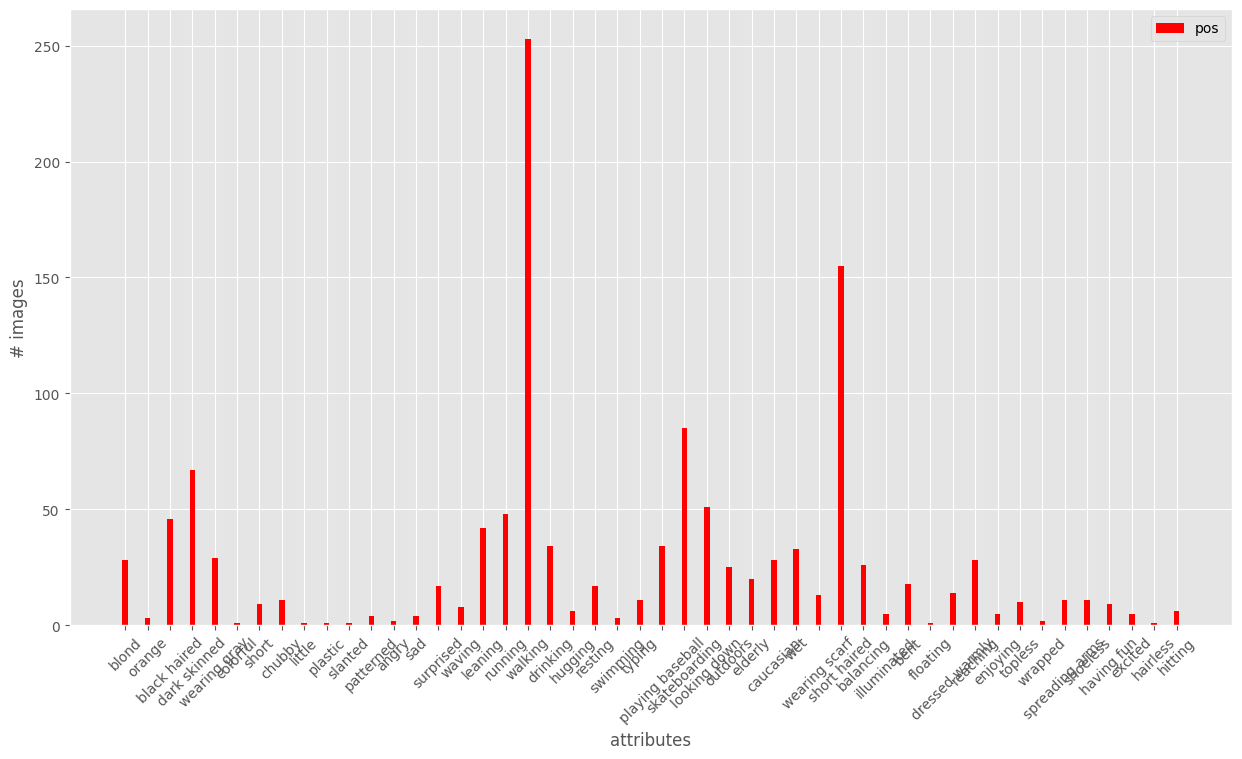

In [306]:
valid_index = oa_anno_pos_train[target_object].nonzero()[0][::5]
valid_names = [attribute_index_reversed[x] for x in valid_index]

shops = valid_names
sales_product_1 = oa_anno_pos_train[target_object][valid_index]
sales_product_2 = oa_anno_neg_train[target_object][valid_index]

# 创建分组柱状图，需要自己控制x轴坐标
xticks = np.arange(len(valid_names))

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(xticks, sales_product_1, width=0.25, label="pos", color="red")

# ax.set_title(str(object_index_reversed[x])+': {}'.format(obj_counter[x]), fontsize=15)
ax.set_xlabel("attributes")
ax.set_ylabel("# images")
ax.legend()

# 最后调整x轴标签的位置
ax.set_xticks(xticks)
ax.set_xticklabels(shops, rotation=45)
print('a')

### 排名靠前的未标注属性是否可以通过类别信息自动标注

In [345]:
pred_ignore_path = '/data/liangkongming/code/KGVA/exp/preds-ignore_224_rn50_obj.npy'
pred_negative_path = '/data/liangkongming/code/KGVA/exp/preds-negative_004_224_rn50_obj.npy'
preds_ignore = np.load(pred_ignore_path)
preds_negative = np.load(pred_negative_path)

In [374]:
def find_invalid_attribute(preds, image_index, top_k):
    anno_image = anno['test'][image_index]
    object_name = anno_image['object_name']
    positive_attributes = anno_image['positive_attributes']
    valid_att_per_obj = np.nonzero(oa_anno_pos_train[object_index[object_name]])[0]
    valid_attributes = [attribute_index_reversed[x] for x in valid_att_per_obj]
    print(object_name, positive_attributes, '{} valid attributes'.format(len(valid_att_per_obj)))

    if top_k == 0:
        top_k = len(positive_attributes)
    pred_attributes = preds[image_index]
    sorted_index = np.argsort(pred_attributes)
    top_k_list = sorted_index[-top_k:][::-1]
    top_k_attributes = [attribute_index_reversed[x] for x in top_k_list]   
#     print(top_k_attributes)

    invalid_preds = [x for x in top_k_attributes if x not in valid_attributes]
#     print(invalid_preds)
    print('invalid attributes: {}/{}'.format(len(invalid_preds), top_k))

In [386]:
image_index = 1302
top_k = 10
find_invalid_attribute(preds_ignore, image_index, top_k)
find_invalid_attribute(preds_negative, image_index, top_k)

sign ['close', 'arrow shaped', 'yellow'] 119 valid attributes
invalid attributes: 7/10
sign ['close', 'arrow shaped', 'yellow'] 119 valid attributes
invalid attributes: 1/10


['puffy', 'indoors', 'aluminum', 'interior', 'chipped', 'adult'] 6 10


In [339]:
# negative
image_index = 0
top_k = 50

anno_image = anno['test'][image_index]
object_name = anno_image['object_name']
positive_attributes = anno_image['positive_attributes']
print(object_name, positive_attributes)
pred_attributes = preds[image_index]
sorted_index = np.argsort(pred_attributes)
top_k_list = sorted_index[-top_k:][::-1]
top_k_attributes = [attribute_index_reversed[x] for x in top_k_list]   
print(top_k_attributes)

floor ['patterned', 'tiled', 'bare']
['tiled', 'beige', 'clean', 'patterned', 'white', 'gray', 'tan', 'brown', 'smooth', 'flat', 'hardwood', 'light colored', 'stone', 'brick', 'cream colored', 'dry', 'speckled', 'shiny', 'long', 'square', 'dotted', 'reflective', 'dirty', 'decorative', 'light brown', 'golden brown', 'mounted', 'yellow', 'large', 'asian', 'spotless', 'hard', 'standing', 'porcelain', 'rectangular', 'ceramic', 'dark colored', 'wooden', 'spotted', 'marble', 'high', 'tight', 'lying', 'old', 'ivory', 'close', 'sunlit', 'modern', 'woven', 'textured']


In [340]:
valid_att_per_obj = np.nonzero(oa_anno_pos_train[object_index[object_name]])[0]
print(len(valid_att_per_obj))
valid_attributes = [attribute_index_reversed[x] for x in valid_att_per_obj]

105


In [341]:
invalid_preds = [x for x in top_k_attributes if x not in valid_attributes]
print(invalid_preds, len(invalid_preds), len(top_k_attributes))

['mounted', 'asian', 'standing', 'porcelain', 'rectangular', 'spotted', 'high', 'tight', 'lying', 'ivory', 'woven'] 11 50


### Next

a


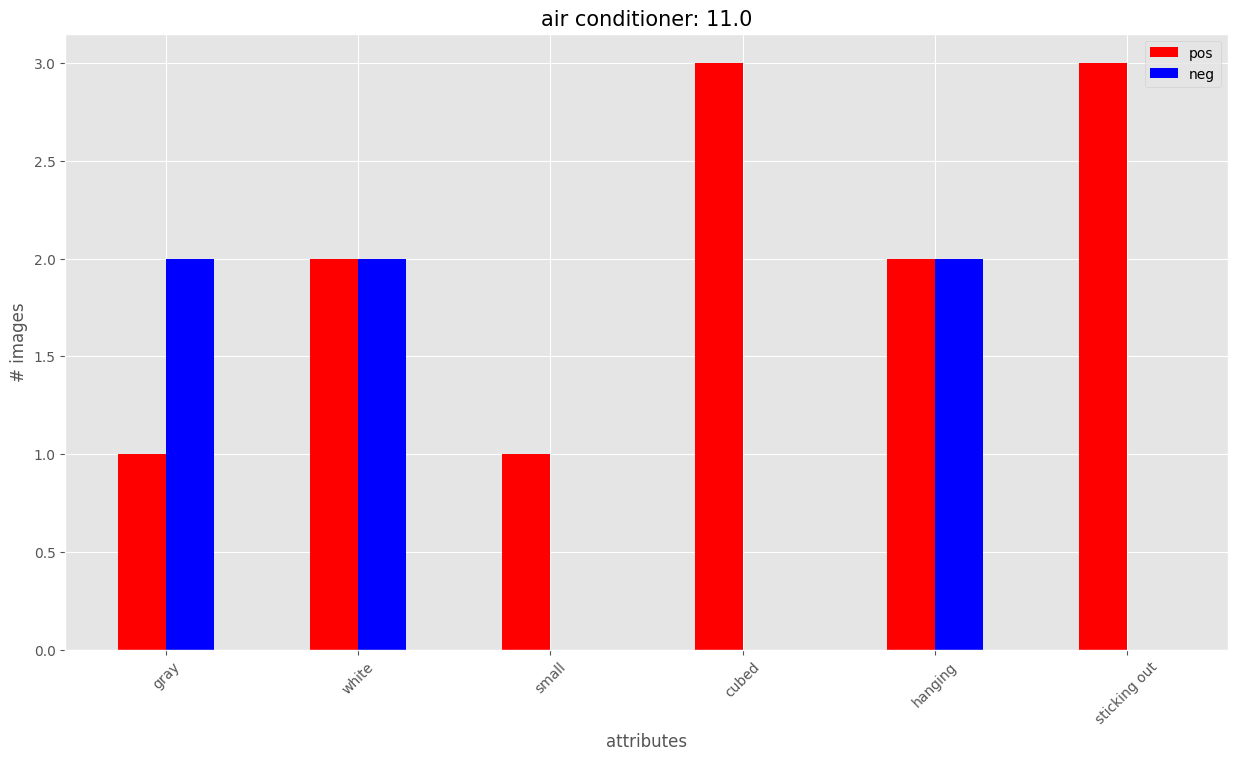

In [121]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use("ggplot")

shops = valid_names
sales_product_1 = obj_att_anno_pos[x][valid_index]
sales_product_2 = obj_att_anno_neg[x][valid_index]

# 创建分组柱状图，需要自己控制x轴坐标
xticks = np.arange(len(valid_names))

fig, ax = plt.subplots(figsize=(15, 8))
# 所有门店第一种产品的销量，注意控制柱子的宽度，这里选择0.25
ax.bar(xticks - 0.25/2, sales_product_1, width=0.25, label="pos", color="red")
# 所有门店第二种产品的销量，通过微调x轴坐标来调整新增柱子的位置
ax.bar(xticks + 0.25/2, sales_product_2, width=0.25, label="neg", color="blue")

ax.set_title(str(object_index_reversed[x])+': {}'.format(obj_counter[x]), fontsize=15)
ax.set_xlabel("attributes")
ax.set_ylabel("# images")
ax.legend()

# 最后调整x轴标签的位置
ax.set_xticks(xticks)
ax.set_xticklabels(shops, rotation=45)
print('a')

In [95]:
xticks

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [ ]:
print('=== Pos: ===')
for y in obj_att_anno_pos[x].nonzero()[0]:
    print(attribute_index_reversed[y])
    
print('=== Neg: ===')
for y in obj_att_anno_neg[x].nonzero()[0]:
    print(attribute_index_reversed[y])